In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Image Libraries
import os

# For displaying images
from PIL import Image

Contents of input directory: ['sample_submission.csv', 'train_labels.csv', 'test', 'train']
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
label
0    130908
1     89117
Name: count, dtype: int64


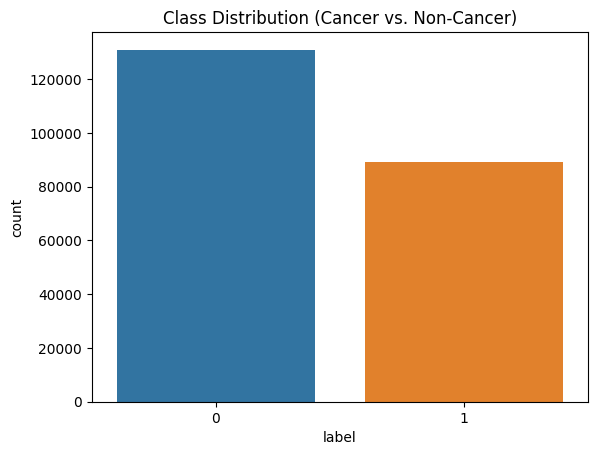

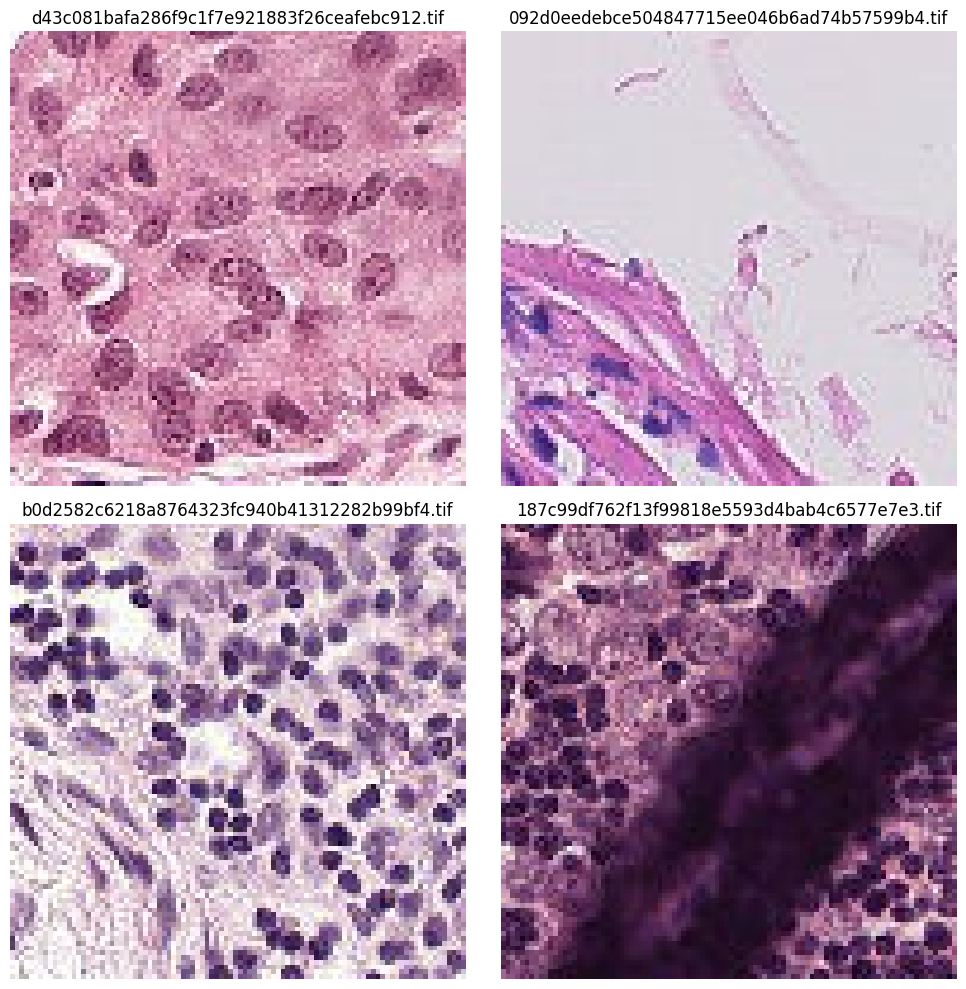

Example image filename: d43c081bafa286f9c1f7e921883f26ceafebc912.tif
Label for the example image: 1


In [2]:
# Check the folder structure and contents
input_dir = "/kaggle/input/histopathologic-cancer-detection"
print("Contents of input directory:", os.listdir(input_dir))

# Load the train labels CSV
labels_path = os.path.join(input_dir, "train_labels.csv")
labels = pd.read_csv(labels_path)

# Display the first few rows of the labels CSV
print(labels.head())

# Step 3: Check the class distribution (tumor vs. no tumor)
print(labels['label'].value_counts())

# Plot class distribution
sns.countplot(x='label', data=labels)
plt.title('Class Distribution (Cancer vs. Non-Cancer)')
plt.show()

# Step 4: Display sample images from the train folder
train_dir = os.path.join(input_dir, "train")
image_files = os.listdir(train_dir)[:10]  # Load a few images for visualization

# Plot a few sample images (adjusting grid size for 4 images)
plt.figure(figsize=(10, 10))

# Select only the first 4 images for the 2x2 grid
for i, file in enumerate(image_files[:4]):
    image = Image.open(os.path.join(train_dir, file))
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(f"{file}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Step 5: Check if train_labels.csv correctly maps to the images in the train folder
print("Example image filename:", image_files[0])
example_image_id = image_files[0].replace(".tif", "")
print("Label for the example image:", labels[labels['id'] == example_image_id]['label'].values[0])



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Using device: cpu


Processing Images: 100%|██████████| 220025/220025 [16:23<00:00, 223.71image/s]


Total valid images: 219996
Total noisy images: 29


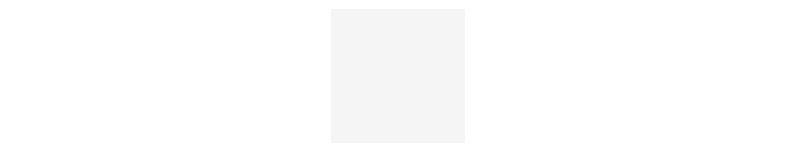

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import random
from tqdm import tqdm

# Defining paths
data_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

# Loading the labels
labels_df = pd.read_csv(labels_path)

# Setting a threshold for percentage of identical pixels 
threshold_percentage = 0.95

# Select device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Transform to convert images to tensors and apply CenterCrop
transform = transforms.Compose([
    transforms.CenterCrop(32),  # Cropping the center to 32x32
    transforms.ToTensor()       # Converting image to tensor
])

# Efficient Dataset class for loading images
class PCamDataset(Dataset):
    def __init__(self, labels_df, data_dir, transform=None):
        self.labels_df = labels_df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_id = self.labels_df.iloc[idx]['id']
        img_path = os.path.join(self.data_dir, img_id + '.tif')
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img_id, img

# Optimized function to check noisy images (batch-wise)
def is_noisy_image_batch(batch_tensor, threshold_percentage):
    """
    This function takes a batch of images and checks for noise in a vectorized manner.
    """
    # Flatten the images into (batch_size, num_pixels, 3)
    flattened_batch = batch_tensor.view(batch_tensor.size(0), -1, batch_tensor.size(1))

    # Check for identical pixels per image
    noisy_images = []
    for img in flattened_batch:
        unique_pixels, counts = img.unique(dim=0, return_counts=True)
        max_pixel_percentage = counts.max().item() / counts.sum().item()
        noisy_images.append(max_pixel_percentage >= threshold_percentage)

    return torch.tensor(noisy_images, device=device)

# Initialize dataset and dataloader
dataset = PCamDataset(labels_df, data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=6, pin_memory=False, persistent_workers=True)

# Lists to store valid (non-noisy) and noisy image IDs
valid_image_ids = []
noisy_image_ids = []
noisy_images_samples = []

# Use a progress bar to monitor processing
with tqdm(total=len(labels_df), desc="Processing Images", unit="image") as pbar:
    for img_ids, imgs in dataloader:
        imgs = imgs.to(device)  # Move batch to GPU
        is_noisy_batch = is_noisy_image_batch(imgs, threshold_percentage)

        # Add non-noisy and noisy image IDs to their respective lists
        valid_image_ids.extend([img_id for img_id, noisy in zip(img_ids, is_noisy_batch) if not noisy])
        noisy_image_ids.extend([img_id for img_id, noisy in zip(img_ids, is_noisy_batch) if noisy])
        
        # Collecting noisy images for later display
        noisy_images_samples.extend([img.cpu() for img, noisy in zip(imgs, is_noisy_batch) if noisy])

        pbar.update(len(img_ids))  # Update progress bar

# Filtering out the labels of valid (clean) and noisy images
clean_labels_df = labels_df[labels_df['id'].isin(valid_image_ids)]
noisy_labels_df = labels_df[labels_df['id'].isin(noisy_image_ids)]

# Saving the clean and noisy labels to CSV files
clean_labels_df.to_csv('clean_train_labels.csv', index=False)
noisy_labels_df.to_csv('noisy_train_labels.csv', index=False)

# Print the total valid and noisy images
print(f"Total valid images: {len(valid_image_ids)}")
print(f"Total noisy images: {len(noisy_image_ids)}")

# Function to display some random noisy images
def display_noisy_images(noisy_images_samples, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        img_tensor = random.choice(noisy_images_samples)  # Randomly select a noisy image
        img_np = img_tensor.permute(1, 2, 0).numpy()  # Convert tensor to numpy for displaying
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_np)
        plt.axis('off')
    plt.show()

# Display 5 random noisy images
display_noisy_images(noisy_images_samples, num_images=5)


In [6]:
# Custom Dataset class optimized for loading images
class CustomDataset(Dataset):
    def __init__(self, labels_df, data_dir, transform=None):
        self.labels_df = labels_df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_id = self.labels_df.iloc[idx]['id']
        label = self.labels_df.iloc[idx]['label']
        img_path = os.path.join(self.data_dir, img_id + '.tif')

        # Load image and apply transformations
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

# Transform to convert images to tensors and apply CenterCrop
transform = transforms.Compose([
    transforms.CenterCrop(32),  # Cropping the center to 32x32
    transforms.ToTensor()       # Converting image to tensor
])


# Create the dataset with transformations
dataset = CustomDataset(labels_df, data_dir, transform=transform)

# Define the batch size and DataLoader settings
batch_size = 64  # You can increase this based on your hardware (e.g., GPU memory)
num_workers = 4   # Adjust based on CPU cores for parallel data loading

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

# Check batch shapes with tqdm progress bar
with tqdm(dataloader, desc="Loading images", unit="batch") as loader:
    for images, labels in loader:
        print(f"Shape of single image: {images[0].shape}")  # Shape of a single image
        print(f"Shape of full image batch: {images.shape}")  # Shape of full batch of images
        break  # Only load one batch for inspection


Loading images:   0%|          | 0/3438 [00:00<?, ?batch/s]

Shape of single image: torch.Size([3, 32, 32])
Shape of full image batch: torch.Size([64, 3, 32, 32])


Loading images:   0%|          | 0/3438 [00:00<?, ?batch/s]


In [7]:
# Function to compute mean and std in a more efficient way
def calculate_mean_std(dataloader, device='cpu'):
    # Initialize variables to store sums of means and squared means
    total_sum = 0.0
    total_sq_sum = 0.0
    total_pixels = 0

    # Move all computations to the appropriate device (GPU if available)
    for images, _ in tqdm(dataloader, desc="Calculating mean and std"):
        images = images.to(device)

        # Reshape the images into [batch_size, channels, height*width] and calculate the sum and squared sum
        pixels_in_batch = images.size(0) * images.size(2) * images.size(3)
        total_pixels += pixels_in_batch

        total_sum += images.sum(dim=[0, 2, 3])
        total_sq_sum += (images ** 2).sum(dim=[0, 2, 3])

    # Calculate mean and std over all the pixels
    mean = total_sum / total_pixels
    std = torch.sqrt((total_sq_sum / total_pixels) - mean**2)

    return mean.cpu(), std.cpu()  # Move results back to CPU if necessary

# Assuming dataloader and device have been set up (e.g., device='cuda' if using a GPU)
mean, std = calculate_mean_std(dataloader, device=device)

print(f'Mean: {mean}')
print(f'Std: {std}')


Calculating mean and std: 100%|██████████| 3438/3438 [03:34<00:00, 16.03it/s]

Mean: tensor([0.7022, 0.5447, 0.6958])
Std: tensor([0.2379, 0.2806, 0.2153])


In [8]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Custom Dataset class for handling PCam data
class PCamDataset(Dataset):
    def __init__(self, labels_df, data_dir, transform=None):
        self.labels_df = labels_df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_id = self.labels_df.iloc[idx]['id']
        img_path = os.path.join(self.data_dir, img_id + '.tif')
        img = Image.open(img_path).convert('RGB')
        label = self.labels_df.iloc[idx]['label']  # Assuming 'label' column exists in the DataFrame
        if self.transform:
            img = self.transform(img)
        return img, label

# Load clean labels DataFrame
clean_labels_df = pd.read_csv('/kaggle/working/clean_train_labels.csv')

# Define the path to the image data
data_dir = '/kaggle/input/histopathologic-cancer-detection/train/'  # Update this path as needed

# 70/10/20 Split: Split dataset into train, validation, and test sets
train_df, temp_df = train_test_split(clean_labels_df, test_size=0.30, stratify=clean_labels_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df['label'], random_state=42)

# Print the number of images in each split
print(f"Train set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")
print(f"Test set size: {len(test_df)} images")

# Define transforms (without data augmentation as requested)
basic_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create datasets
train_dataset = PCamDataset(train_df, data_dir, transform=basic_transform)
val_dataset = PCamDataset(val_df, data_dir, transform=basic_transform)
test_dataset = PCamDataset(test_df, data_dir, transform=basic_transform)

# Define batch size
batch_size = 128

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print("DataLoaders created for train, validation, and test sets.")



Train set size: 153997 images
Validation set size: 44219 images
Test set size: 21780 images
DataLoaders created for train, validation, and test sets.


In [9]:
# Function to calculate and display the percentage distribution of labels
def print_distribution(label_counts, dataset_name):
    total = label_counts.sum()
    non_cancerous_percentage = (label_counts[0] / total) * 100
    cancerous_percentage = (label_counts[1] / total) * 100
    
    print(f"{dataset_name} set distribution:")
    print(f"Non-cancerous: {label_counts[0]} ({non_cancerous_percentage:.2f}%)")
    print(f"Cancerous: {label_counts[1]} ({cancerous_percentage:.2f}%)\n")

# Get the label counts for each dataset
train_distribution = train_df['label'].value_counts()
val_distribution = val_df['label'].value_counts()
test_distribution = test_df['label'].value_counts()

# Print the percentage distribution for each dataset
print_distribution(train_distribution, "Train")
print_distribution(val_distribution, "Validation")
print_distribution(test_distribution, "Test")


Train set distribution:
Non-cancerous: 91615 (59.49%)
Cancerous: 62382 (40.51%)

Validation set distribution:
Non-cancerous: 26307 (59.49%)
Cancerous: 17912 (40.51%)

Test set distribution:
Non-cancerous: 12957 (59.49%)
Cancerous: 8823 (40.51%)



In [10]:
import torch
from torch.utils.data import DataLoader, Subset
import random
from tqdm import tqdm  # Import tqdm for progress bar

# Function to create a balanced data loader with a specified ratio of cancerous to non-cancerous samples
def create_balanced_loader(data_loader, cancerous_label, non_cancerous_label, cancerous_ratio=0.2):
    cancerous_indices = []
    non_cancerous_indices = []
    
    # Separating cancerous and non-cancerous samples
    print("Separating cancerous and non-cancerous samples...")
    for idx, (_, labels) in tqdm(enumerate(data_loader.dataset), total=len(data_loader.dataset), desc="Processing"):
        if labels == cancerous_label:
            cancerous_indices.append(idx)
        else:
            non_cancerous_indices.append(idx)
    
    # Shuffle and select indices
    random.shuffle(cancerous_indices)
    random.shuffle(non_cancerous_indices)
    
    num_cancerous = int(len(cancerous_indices) * cancerous_ratio)
    num_non_cancerous = int(len(non_cancerous_indices) * (1 - cancerous_ratio))
    
    selected_cancerous_indices = cancerous_indices[:num_cancerous]
    selected_non_cancerous_indices = non_cancerous_indices[:num_non_cancerous]
    
    # Combine and shuffle the selected indices
    new_indices = selected_cancerous_indices + selected_non_cancerous_indices
    random.shuffle(new_indices)
    
    # Create the new dataset and data loader
    new_subset = Subset(data_loader.dataset, new_indices)
    new_loader = DataLoader(new_subset, batch_size=data_loader.batch_size, shuffle=True, drop_last=True)
    
    return new_loader

# Function to check the distribution of samples in a data loader
def check_distribution(data_loader, cancerous_label):
    cancer_count = 0
    non_cancer_count = 0
    
    print("Checking distribution in the new data loader...")
    for _, labels in tqdm(data_loader, desc="Checking"):
        cancer_count += (labels == cancerous_label).sum().item()
        non_cancer_count += (labels != cancerous_label).sum().item()
    
    total_count = cancer_count + non_cancer_count
    return cancer_count, non_cancer_count, total_count

# Define your cancerous and non-cancerous labels
cancerous_label = 1
non_cancerous_label = 0

# Create new data loaders with a balanced distribution for validation and test sets
new_val_loader = create_balanced_loader(val_loader, cancerous_label, non_cancerous_label, cancerous_ratio=0.2)
new_test_loader = create_balanced_loader(test_loader, cancerous_label, non_cancerous_label, cancerous_ratio=0.2)

# Check and print the distribution for the new validation loader
val_cancer_count, val_non_cancer_count, val_total_count = check_distribution(new_val_loader, cancerous_label)
print(f"New Validation Loader Distribution: Cancerous: {val_cancer_count}, Non-Cancerous: {val_non_cancer_count}, Total: {val_total_count}")

# Check and print the distribution for the new test loader
test_cancer_count, test_non_cancer_count, test_total_count = check_distribution(new_test_loader, cancerous_label)
print(f"New Test Loader Distribution: Cancerous: {test_cancer_count}, Non-Cancerous: {test_non_cancer_count}, Total: {test_total_count}")


Separating cancerous and non-cancerous samples...


Processing: 100%|██████████| 44219/44219 [01:48<00:00, 409.13it/s]


Separating cancerous and non-cancerous samples...


Processing: 100%|██████████| 21780/21780 [00:54<00:00, 401.48it/s]


Checking distribution in the new data loader...


Checking: 100%|██████████| 192/192 [01:00<00:00,  3.20it/s]


New Validation Loader Distribution: Cancerous: 3575, Non-Cancerous: 21001, Total: 24576
Checking distribution in the new data loader...


Checking: 100%|██████████| 94/94 [00:29<00:00,  3.23it/s]

New Test Loader Distribution: Cancerous: 1756, Non-Cancerous: 10276, Total: 12032
